
# Importamos Librerias

In [1]:
# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from random import random

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Evaluacion
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

#Otros Modelos

# Modelos ML de Regresion

import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from prophet import Prophet

import pickle
import os

from datetime import datetime

from sklearn.model_selection import RandomizedSearchCV


#Tamño default de los plots
plt.rcParams["figure.figsize"] = [10,6]



# Importamos DATASET

In [2]:
# Leemos los ficheros
DATA_PATH = 'C:/Users/mpgir/Desktop/Data Science/Capstone/DS-Capstone-Market/data/'
df= pd.read_csv(DATA_PATH+'daily_sales_cleandata.csv')

In [3]:
#Creamos una copia del original para cuando se reinicia el kernel.
df_forecast= df.copy()

In [4]:
#Miramos cuantas filas y columnas tiene el df daily_sales_cleandata
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 15 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           object 
 1   item         object 
 2   category     object 
 3   department   object 
 4   store        object 
 5   store_code   object 
 6   region       object 
 7   d            object 
 8   qty_sold     int64  
 9   date         object 
 10  weekday_int  int64  
 11  holiday      int64  
 12  weekend      int64  
 13  yearweek     int64  
 14  sell_price   float64
dtypes: float64(1), int64(5), object(9)
memory usage: 6.5+ GB


Agrupamos por mes, para hacer más manejable el dataset, ya que por memoria, no es posible hacerlo por Yearweek

In [5]:
#Convertimos la fecha a formato datetime y creamos columnas Month y Year
df_forecast['date'] = pd.to_datetime(df_forecast['date'])
df_forecast['month'] = df_forecast['date'].dt.month
df_forecast['year'] = df_forecast['date'].dt.year


In [6]:
df_forecast['month_year'] = pd.to_datetime(df_forecast['year'].astype(str) + '-' + df_forecast['month'].astype(str), format='%Y-%m')

In [7]:
#Agrupamos las columnas con qty_sold y month
df_forecast= (df_forecast
                   .groupby(['id', 'item', 'category', 'department', 'store', 'store_code', 'region', 'month_year'], as_index=False)
                   .agg({'qty_sold': 'sum', 'sell_price': 'median'})
                   )

In [8]:
df_forecast.head()

,id,item,category,department,store,store_code,region,month_year,qty_sold,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-01,0,12.7414
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,0,12.7414
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-03-01,0,12.7414
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-04-01,0,12.7414
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-05-01,0,12.7414


In [9]:
"""#Dejamos sólo las columnas que necesitamos, aquellas que nos dan mayor granularidad las eliminamos.
df_forecast = df_forecast.drop(columns=["d", "weekday_int", "yearweek", "holiday", "weekend", "date"])"""

'#Dejamos sólo las columnas que necesitamos, aquellas que nos dan mayor granularidad las eliminamos.\ndf_forecast = df_forecast.drop(columns=["d", "weekday_int", "yearweek", "holiday", "weekend", "date"])'

In [10]:
# 3.363.362 rows × 10 columns registros con venta cero, que son el 40% del total de registros.
venta_cero=df_forecast [df_forecast['qty_sold']<=0]

In [11]:
venta_cero["id"].value_counts() #vemos que no es un producto en especial, sino varios.

id
HOME_&_GARDEN_1_032_BOS_1    62
HOME_&_GARDEN_1_400_NYC_4    62
SUPERMARKET_3_778_NYC_2      62
HOME_&_GARDEN_1_278_NYC_3    61
SUPERMARKET_3_595_NYC_3      61
                             ..
ACCESORIES_1_164_BOS_1        1
ACCESORIES_1_164_NYC_4        1
ACCESORIES_1_164_PHI_3        1
HOME_&_GARDEN_2_325_BOS_3     1
HOME_&_GARDEN_1_327_PHI_3     1
Name: count, Length: 28021, dtype: int64

In [12]:
venta_cero["month_year"].value_counts() #también son varios meses y años

month_year
2011-01-01    21039
2011-02-01    17688
2011-03-01    17313
2011-05-01    17052
2011-06-01    16997
              ...  
2015-05-01     2967
2015-10-01     2678
2016-02-01     2432
2016-03-01     1952
2016-04-01     1801
Name: count, Length: 64, dtype: int64

In [13]:
#Tenemos 30.490 series temporales
df_forecast["id"].nunique()

30490

In [14]:
MIN_DATE = df_forecast["month_year"].min()
MAX_DATE = df_forecast["month_year"].max()

In [ ]:
MIN_DATE = df_forecast["date"].min()
MAX_DATE = df_forecast["date"].max()

In [15]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}") 

Min date is 2011-01-01 00:00:00
Max date is 2016-04-01 00:00:00


In [16]:
df_forecast.isnull().sum() #No tenemos nulos porque anteriormente los imputamos con el bfil y ffill en notebook dataclean

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
month_year    0
qty_sold      0
sell_price    0
dtype: int64


# Data Imputation


In [17]:
sample_ts = "HOME_&_GARDEN_1_020_NYC_3" # selecionamos una serie temporal, para analizar despues

In [18]:
df_forecast[df_forecast["id"] == sample_ts]

,id,item,category,department,store,store_code,region,month_year,qty_sold,sell_price
374080,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-01-01,0,8.7125
374081,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-02-01,0,8.7125
374082,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-03-01,0,8.7125
374083,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-04-01,0,8.7125
374084,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2011-05-01,0,8.7125
...,...,...,...,...,...,...,...,...,...,...
374139,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2015-12-01,0,8.7125
374140,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2016-01-01,0,8.7125
374141,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2016-02-01,0,8.7125
374142,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,2016-03-01,5,8.7125


In [19]:
# Ordenar el DataFrame por las columnas "id" y "month"
df_forecast.sort_values(["id", "month_year"], ascending=True, inplace=True)

In [20]:
df_forecast.head()

,id,item,category,department,store,store_code,region,month_year,qty_sold,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-01,0,12.7414
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-01,0,12.7414
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-03-01,0,12.7414
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-04-01,0,12.7414
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-05-01,0,12.7414


In [21]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951360 entries, 0 to 1951359
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        object        
 2   category    object        
 3   department  object        
 4   store       object        
 5   store_code  object        
 6   region      object        
 7   month_year  datetime64[ns]
 8   qty_sold    int64         
 9   sell_price  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 148.9+ MB


In [22]:
month_column = df_forecast.pop("month_year")
id_column = df_forecast.pop('id')
df_forecast.insert(0, 'month_year', month_column)
df_forecast.insert(1, 'id', id_column)

In [23]:
df_forecast[df_forecast["id"] == sample_ts]

,month_year,id,item,category,department,store,store_code,region,qty_sold,sell_price
374080,2011-01-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
374081,2011-02-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
374082,2011-03-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
374083,2011-04-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
374084,2011-05-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
...,...,...,...,...,...,...,...,...,...,...
374139,2015-12-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
374140,2016-01-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
374141,2016-02-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,0,8.7125
374142,2016-03-01,HOME_&_GARDEN_1_020_NYC_3,HOME_&_GARDEN_1_020,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,5,8.7125


# EDA

### --> 1. EDA: Global Sales

In [24]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)
    

In [25]:
"""df_forecast['month_year'] = df_forecast['month'].dt.to_timestamp()"""

"df_forecast['month_year'] = df_forecast['month'].dt.to_timestamp()"

In [55]:
y = df_forecast.groupby("month_year")["qty_sold"].sum()

In [56]:
y = y.iloc[:-2]

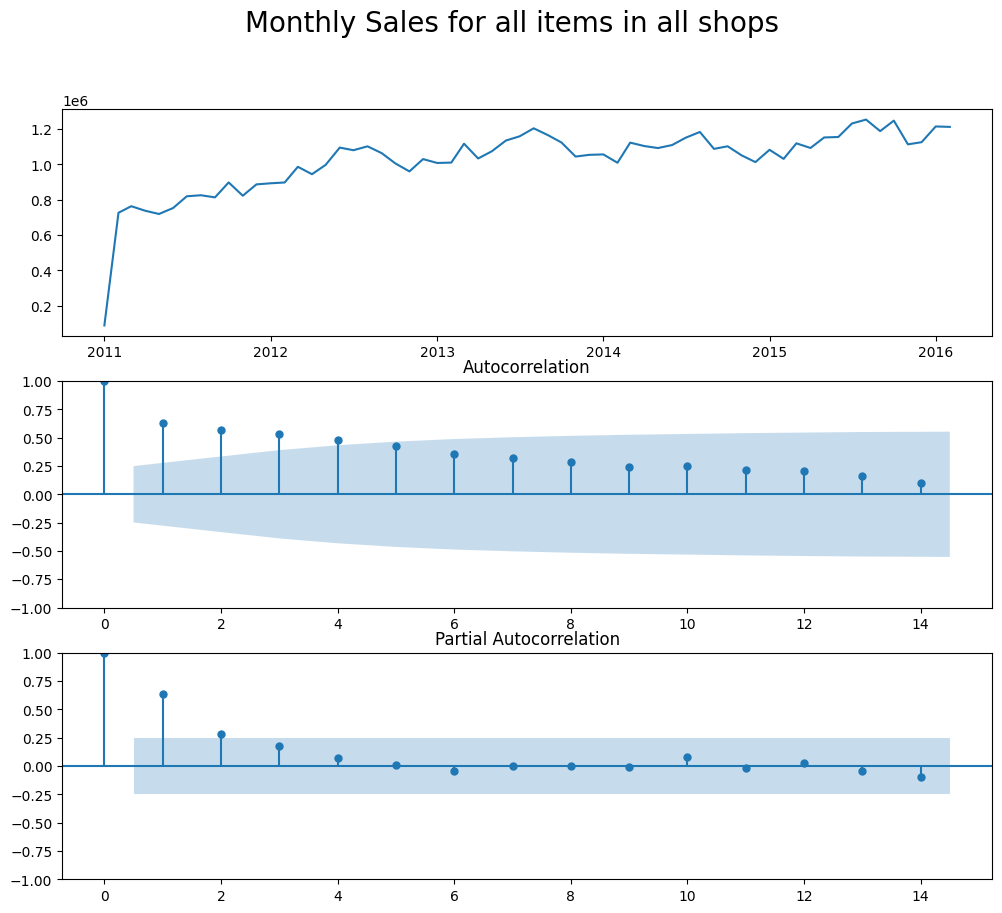

In [57]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Analizamos los peaks en ventas del 2016. probablemente Reyes!!

<Axes: xlabel='month_year'>

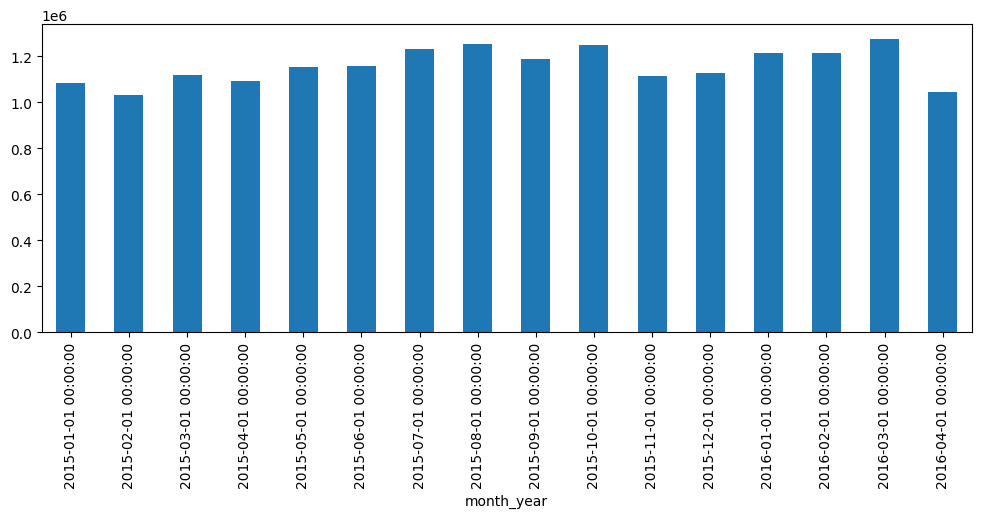

In [58]:
(df_forecast[(df_forecast["month_year"].dt.year == 2015) | (df_forecast['month_year'].dt.year == 2016)]
 .groupby(["month_year"])["qty_sold"].sum()
 .sort_index()  # Ordena en orden cronológico
 .plot(kind="bar", figsize=(12, 4))
)

In [59]:
df_forecast[df_forecast["month_year"]== "2016-01-01"].sort_values (by="qty_sold", ascending=False)


,month_year,id,item,category,department,store,store_code,region,qty_sold,sell_price,qty_sold_lag1
1500540,2016-01-01,SUPERMARKET_3_120_NYC_3,SUPERMARKET_3_120,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2474,5.976,2142.0
1481340,2016-01-01,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2379,1.920,202.0
1798524,2016-01-01,SUPERMARKET_3_586_BOS_2,SUPERMARKET_3_586,SUPERMARKET,SUPERMARKET_3,Roxbury,BOS_2,Boston,2205,2.016,3159.0
1481596,2016-01-01,SUPERMARKET_3_090_PHI_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2082,1.656,147.0
1798588,2016-01-01,SUPERMARKET_3_586_BOS_3,SUPERMARKET_3_586,SUPERMARKET,SUPERMARKET_3,Back_Bay,BOS_3,Boston,1926,2.016,2507.0
...,...,...,...,...,...,...,...,...,...,...,...
1810684,2016-01-01,SUPERMARKET_3_605_BOS_2,SUPERMARKET_3_605,SUPERMARKET,SUPERMARKET_3,Roxbury,BOS_2,Boston,0,3.216,0.0
1810748,2016-01-01,SUPERMARKET_3_605_BOS_3,SUPERMARKET_3_605,SUPERMARKET,SUPERMARKET_3,Back_Bay,BOS_3,Boston,0,3.216,0.0
1810812,2016-01-01,SUPERMARKET_3_605_NYC_1,SUPERMARKET_3_605,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,0,3.216,0.0
1810876,2016-01-01,SUPERMARKET_3_605_NYC_2,SUPERMARKET_3_605,SUPERMARKET,SUPERMARKET_3,Harlem,NYC_2,New York,0,3.216,0.0


<Axes: xlabel='month_year,item'>

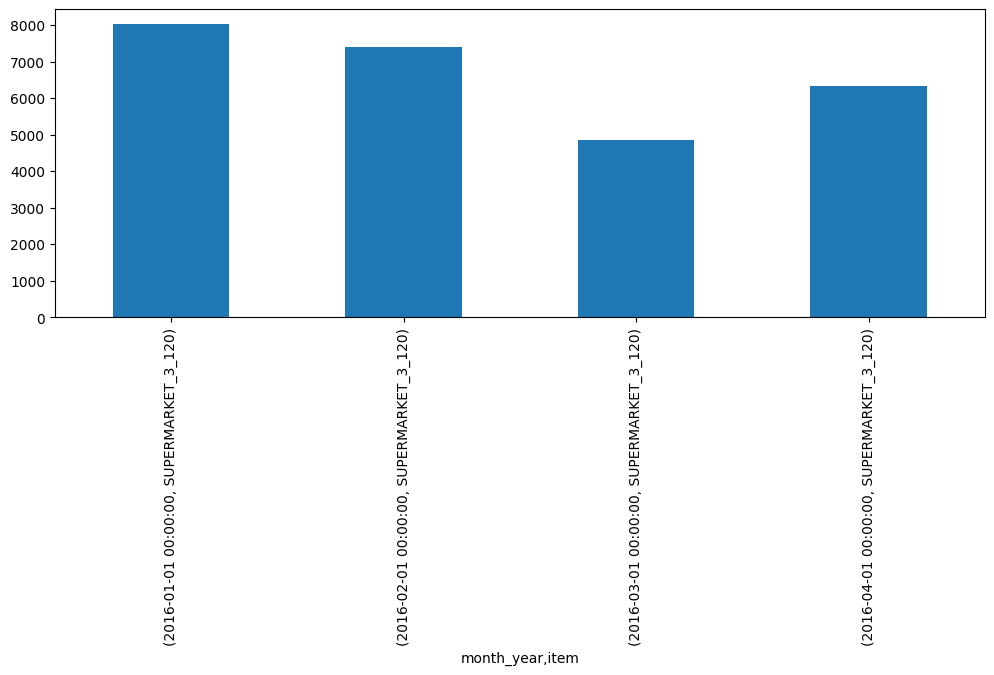

In [60]:
(df_forecast[(df_forecast['month_year'].dt.year == 2016) & (df_forecast['item'] == "SUPERMARKET_3_120")]
               .groupby(["month_year", "item"])["qty_sold"].sum()
               .sort_index()  # Ordena en orden cronológico
               .plot(kind="bar", figsize=(12, 4))
              )
#Miramos este producto como ejemplo, venta por semanas y evolución de precio

<Axes: xlabel='id'>

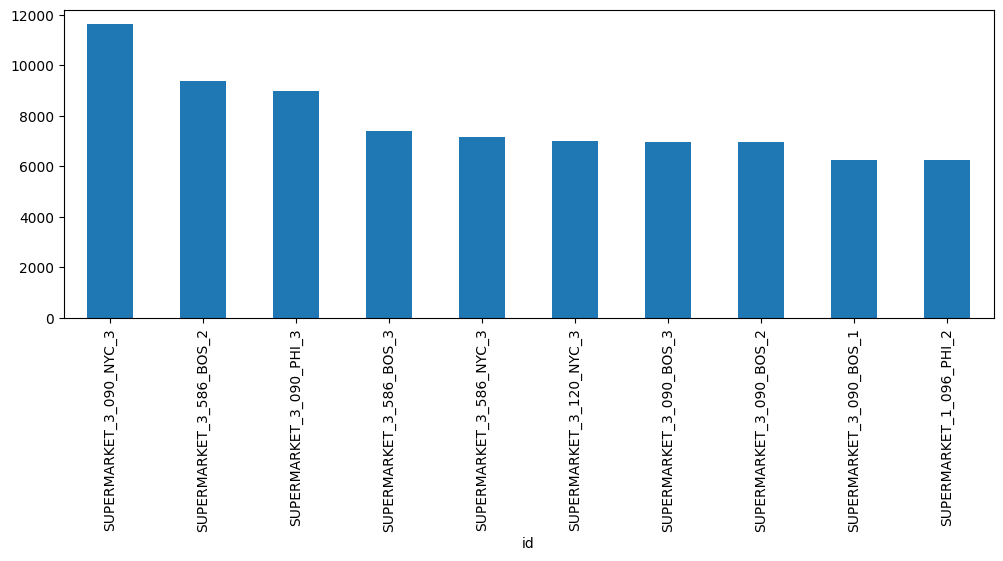

In [61]:
top_10_items = (df_forecast[df_forecast['month_year'].dt.year == 2016]
                .groupby(["id"])["qty_sold"].sum()
                .sort_values(ascending=False)  # Ordena en orden descendente
                .head(10)  # Selecciona los top 10
               )
top_10_items.plot(kind="bar", figsize=(12, 4))

### --> 2. EDA: Top 3 Stores

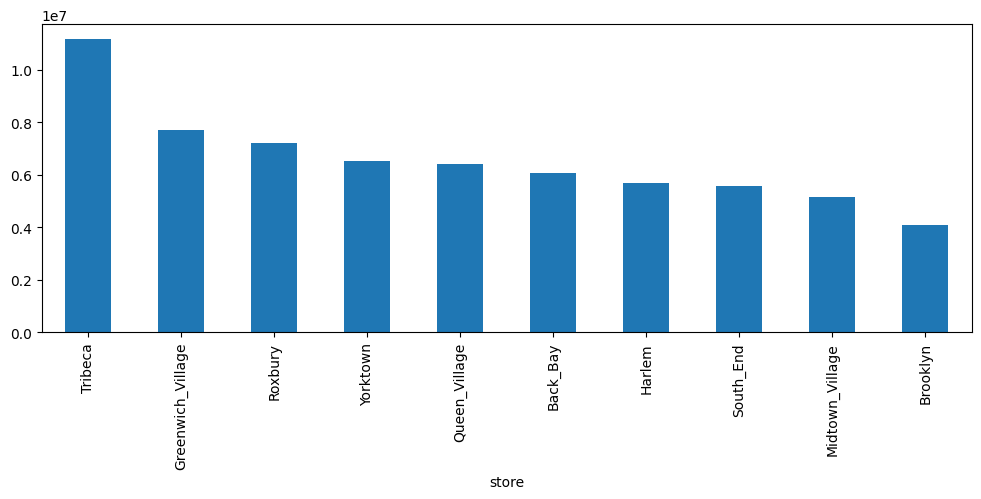

In [62]:
(
    df_forecast.
    groupby(["store"])
    ["qty_sold"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [63]:
df_forecast["store"].value_counts() #10 tiendas

store
South_End            195136
Roxbury              195136
Back_Bay             195136
Greenwich_Village    195136
Harlem               195136
Tribeca              195136
Brooklyn             195136
Midtown_Village      195136
Yorktown             195136
Queen_Village        195136
Name: count, dtype: int64

In [64]:
df_forecast["item"].value_counts() #3049 ítems

item
ACCESORIES_1_001       640
SUPERMARKET_2_210      640
SUPERMARKET_2_201      640
SUPERMARKET_2_202      640
SUPERMARKET_2_203      640
                      ... 
HOME_&_GARDEN_1_464    640
HOME_&_GARDEN_1_465    640
HOME_&_GARDEN_1_466    640
HOME_&_GARDEN_1_467    640
SUPERMARKET_3_827      640
Name: count, Length: 3049, dtype: int64


### --> 3. EDA: Top 3 Departments


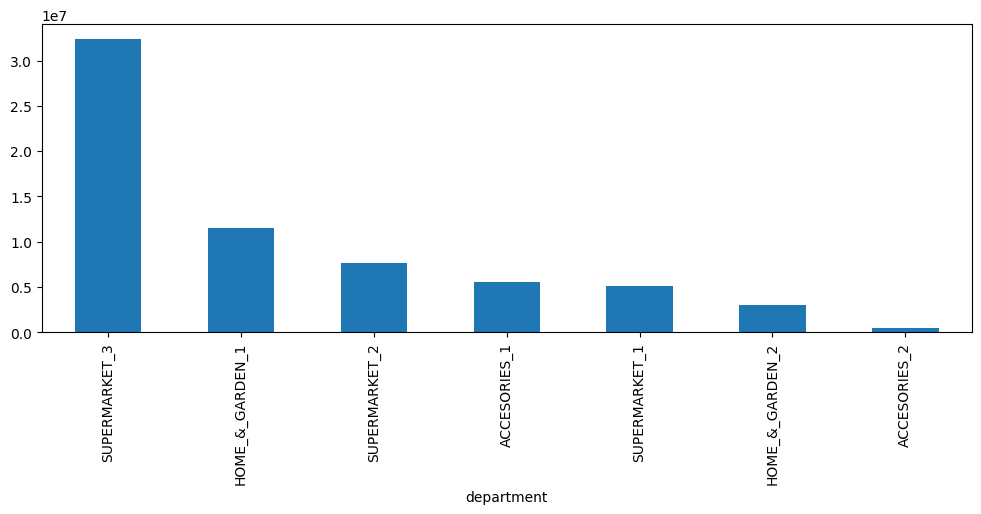

In [65]:
(
    df_forecast.
    groupby(["department"])
    ["qty_sold"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

# Build Time Series Features

In [66]:
df_forecast['qty_sold_lag1'] = df_forecast['qty_sold'].shift(1)

In [67]:
"""df_forecast.groupby('item')['qty_sold_lag1'].sum().reset_index()"""

"df_forecast.groupby('item')['qty_sold_lag1'].sum().reset_index()"

In [69]:
"""def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):
    
    assert "month_year" in df.columns.tolist(), "month_year must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df_forecast
        .set_index("month_year")
        .groupby(gb_list)
        .resample("Y")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
        
    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    
   print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_"""

'def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):\n    \n    assert "month_year" in df.columns.tolist(), "month_year must be in df columns"\n    \n    new_name = "_".join(gb_list + [target_column] + [agg_func_name])\n\n    gb_df_ = (\n        df_forecast\n        .set_index("month_year")\n        .groupby(gb_list)\n        .resample("Y")[target_column]\n        .apply(agg_func)\n        .to_frame()\n        .reset_index()\n        .rename(\n            columns = {\n                target_column : new_name\n            }\n        )\n    )\n        \n    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(\n        lambda series: series.shift(1)\n    )\n    \n   print(f"Dropping columns that might cause target leakage {new_name}")\n    gb_df_.drop(new_name, inplace = True, axis = 1)\n    \n    return gb_df_'

In [70]:
"""GB_LIST = ["item"]
TARGET_COLUMN = "qty_sold"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_.head()"""

'GB_LIST = ["item"]\nTARGET_COLUMN = "qty_sold"\nAGG_FUNC = np.sum\nAGG_FUNC_NAME = "sum"\n\nvars_ts_ = build_ts_vars(\n    df = df_forecast,\n    gb_list = GB_LIST,\n    target_column = TARGET_COLUMN,\n    agg_func = AGG_FUNC,\n    agg_func_name =  AGG_FUNC_NAME\n    \n)\n\nvars_ts_.head()'

### Join TS Features

In [71]:
"""print(df_forecast.shape)

df = pd.merge(df_forecast, vars_ts_, on = ["month_year"] + GB_LIST, how = "left")

print(df.shape)"""

'print(df_forecast.shape)\n\ndf = pd.merge(df_forecast, vars_ts_, on = ["month_year"] + GB_LIST, how = "left")\n\nprint(df.shape)'

In [72]:
df=df_forecast.copy()

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951360 entries, 0 to 1951359
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   month_year     datetime64[ns]
 1   id             object        
 2   item           object        
 3   category       object        
 4   department     object        
 5   store          object        
 6   store_code     object        
 7   region         object        
 8   qty_sold       int64         
 9   sell_price     float64       
 10  qty_sold_lag1  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 163.8+ MB


In [74]:
df.isnull().sum() #Revisamos Nulos, que solo tienen que estar en el registro 1 de nuestro dataset

month_year       0
id               0
item             0
category         0
department       0
store            0
store_code       0
region           0
qty_sold         0
sell_price       0
qty_sold_lag1    1
dtype: int64

In [75]:
"""df["item_qty_sold_sum_lag1"].fillna(-999, inplace = True)
df["item_qty_sold_sum_lag2"].fillna(-999, inplace = True)
df["item_qty_sold_sum_lag3"].fillna(-999, inplace = True)"""

'df["item_qty_sold_sum_lag1"].fillna(-999, inplace = True)\ndf["item_qty_sold_sum_lag2"].fillna(-999, inplace = True)\ndf["item_qty_sold_sum_lag3"].fillna(-999, inplace = True)'

In [76]:
df.head()

,month_year,id,item,category,department,store,store_code,region,qty_sold,sell_price,qty_sold_lag1
0,2011-01-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,NaN
1,2011-02-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0.0
2,2011-03-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0.0
3,2011-04-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0.0
4,2011-05-01,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,0,12.7414,0.0


Para hacer el subsample, teniendo en cuenta los últimos 2 años y medio de los productos que hacen el 60% de la venta

In [77]:
#Definimos fecha máx. calculamos ultimos 2 años y medio recientes y aplicamos fórmula cumsum
max_month_year = df['month_year'].max()
df_2years = max_month_year - pd.DateOffset(years=2, months=6)
df_2MAT= df[df['month_year']>= df_2years]

In [78]:
# Aplica la lógica existente para obtener los productos que representan el 60% de las ventas
df_sample_id= df_2MAT.groupby("id")["qty_sold"].sum().sort_values(ascending=False).cumsum().div(df_2MAT["qty_sold"].sum()).loc[lambda x: x <= 0.6].index

In [79]:
df_sample_top60 = df[df["id"].isin(df_sample_id)]

In [80]:
df_sample_top60.head()

,month_year,id,item,category,department,store,store_code,region,qty_sold,sell_price,qty_sold_lag1
2112,2011-01-01,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,5.7722,23.0
2113,2011-02-01,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,5.7722,0.0
2114,2011-03-01,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,17,5.7722,0.0
2115,2011-04-01,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,23,5.7722,17.0
2116,2011-05-01,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,34,5.7722,23.0


In [81]:
df_sample_top60.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276928 entries, 2112 to 1951231
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   month_year     276928 non-null  datetime64[ns]
 1   id             276928 non-null  object        
 2   item           276928 non-null  object        
 3   category       276928 non-null  object        
 4   department     276928 non-null  object        
 5   store          276928 non-null  object        
 6   store_code     276928 non-null  object        
 7   region         276928 non-null  object        
 8   qty_sold       276928 non-null  int64         
 9   sell_price     276928 non-null  float64       
 10  qty_sold_lag1  276928 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 25.4+ MB


In [82]:
df_sample_top60.shape

(276928, 11)

In [83]:
df_encoded = df_sample_top60.copy()

In [84]:
df_encoded["item"].value_counts()

item
SUPERMARKET_1_110      640
SUPERMARKET_3_393      640
SUPERMARKET_3_090      640
SUPERMARKET_3_064      640
SUPERMARKET_3_234      640
                      ... 
HOME_&_GARDEN_1_449     64
HOME_&_GARDEN_1_440     64
HOME_&_GARDEN_1_431     64
HOME_&_GARDEN_1_413     64
HOME_&_GARDEN_1_287     64
Name: count, Length: 972, dtype: int64

# Encoding categoricos

In [91]:
# Print categoricos
cat_cols = list(df_encoded.select_dtypes(include=['object','category']).columns)
cat_cols

['id', 'item', 'category', 'department', 'store', 'store_code', 'region']

In [92]:
# Inicializamos el codificador de etiquetas
label_encoder = LabelEncoder()

# Iteramos sobre todas las columnas categóricas y aplicamos el Label Encoding
for col in cat_cols:
    df_encoded[col + '_encoded'] = label_encoder.fit_transform(df_encoded[col])

# Eliminamos las columnas categóricas originales si es necesario
df_encoded.drop(columns=cat_cols, inplace=True)

# Imprimimos el DataFrame resultante
print(df_encoded)


        month_year  qty_sold  sell_price  qty_sold_lag1  id_encoded  \
2112    2011-01-01         0      5.7722           23.0           0   
2113    2011-02-01         0      5.7722            0.0           0   
2114    2011-03-01        17      5.7722            0.0           0   
2115    2011-04-01        23      5.7722           17.0           0   
2116    2011-05-01        34      5.7722           23.0           0   
...            ...       ...         ...            ...         ...   
1951227 2015-12-01        84      1.2000           95.0        4326   
1951228 2016-01-01       109      1.2000           84.0        4326   
1951229 2016-02-01       107      1.2000          109.0        4326   
1951230 2016-03-01       130      1.2000          107.0        4326   
1951231 2016-04-01        75      1.2000          130.0        4326   

         item_encoded  category_encoded  department_encoded  store_encoded  \
2112                0                 0                   0          

In [93]:
"""df_encoded = pd.get_dummies(df_encoded, columns=cat_cols)"""

'df_encoded = pd.get_dummies(df_encoded, columns=cat_cols)'

In [94]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276928 entries, 2112 to 1951231
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          276928 non-null  datetime64[ns]
 1   qty_sold            276928 non-null  int64         
 2   sell_price          276928 non-null  float64       
 3   qty_sold_lag1       276928 non-null  float64       
 4   id_encoded          276928 non-null  int32         
 5   item_encoded        276928 non-null  int32         
 6   category_encoded    276928 non-null  int32         
 7   department_encoded  276928 non-null  int32         
 8   store_encoded       276928 non-null  int32         
 9   store_code_encoded  276928 non-null  int32         
 10  region_encoded      276928 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(7), int64(1)
memory usage: 18.0 MB


In [95]:
df_encoded.shape

(276928, 11)

# Eliminamos Alta correlación

# Eliminamos Baja Varianza

# Train Test Split

In [96]:
df2=df_encoded.copy()

In [ ]:
#df2.fillna(0, inplace=True)

In [97]:
df2.head()

,month_year,qty_sold,sell_price,qty_sold_lag1,id_encoded,item_encoded,category_encoded,department_encoded,store_encoded,store_code_encoded,region_encoded
2112,2011-01-01,0,5.7722,23.0,0,0,0,0,2,3,1
2113,2011-02-01,0,5.7722,0.0,0,0,0,0,2,3,1
2114,2011-03-01,17,5.7722,0.0,0,0,0,0,2,3,1
2115,2011-04-01,23,5.7722,17.0,0,0,0,0,2,3,1
2116,2011-05-01,34,5.7722,23.0,0,0,0,0,2,3,1


In [98]:
df2.shape

(276928, 11)

In [99]:
df2.columns.tolist()

['month_year',
 'qty_sold',
 'sell_price',
 'qty_sold_lag1',
 'id_encoded',
 'item_encoded',
 'category_encoded',
 'department_encoded',
 'store_encoded',
 'store_code_encoded',
 'region_encoded']

In [100]:
COLUMNS_TO_DROP = [ 
]
df2.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [101]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276928 entries, 2112 to 1951231
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          276928 non-null  datetime64[ns]
 1   qty_sold            276928 non-null  int64         
 2   sell_price          276928 non-null  float64       
 3   qty_sold_lag1       276928 non-null  float64       
 4   id_encoded          276928 non-null  int32         
 5   item_encoded        276928 non-null  int32         
 6   category_encoded    276928 non-null  int32         
 7   department_encoded  276928 non-null  int32         
 8   store_encoded       276928 non-null  int32         
 9   store_code_encoded  276928 non-null  int32         
 10  region_encoded      276928 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(7), int64(1)
memory usage: 18.0 MB


In [102]:
df2.shape

(276928, 11)

In [103]:
train_index = sorted(list(df2["month_year"].unique()))[:-2]

valida_index = [sorted(list(df2["month_year"].unique()))[-2]]

test_index = [sorted(list(df2["month_year"].unique()))[-1]]

In [104]:
valida_index

[Timestamp('2016-03-01 00:00:00')]

In [105]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2011-01-01 00:00:00'), Timestamp('2011-02-01 00:00:00')] - ... - [Timestamp('2016-01-01 00:00:00'), Timestamp('2016-02-01 00:00:00')]

Our validation index is [Timestamp('2016-03-01 00:00:00')]

Our test/prediction index is [Timestamp('2016-04-01 00:00:00')]



In [106]:
X_train = df2[df2["month_year"].isin(train_index)].drop(['qty_sold', "month_year"], axis=1)
Y_train = df2[df2["month_year"].isin(train_index)]['qty_sold']

X_valida = df2[df2["month_year"].isin(valida_index)].drop(['qty_sold', "month_year"], axis=1)
Y_valida = df2[df2["month_year"].isin(valida_index)]['qty_sold']

X_test = df2[df2["month_year"].isin(test_index)].drop(['qty_sold', "month_year"], axis = 1)
Y_test = df2[df2["month_year"].isin(test_index)]['qty_sold']

In [107]:
X_train.head(20) #Comprobamos que esté en orden las fechas

,sell_price,qty_sold_lag1,id_encoded,item_encoded,category_encoded,department_encoded,store_encoded,store_code_encoded,region_encoded
2112,5.7722,23.0,0,0,0,0,2,3,1
2113,5.7722,0.0,0,0,0,0,2,3,1
2114,5.7722,0.0,0,0,0,0,2,3,1
2115,5.7722,17.0,0,0,0,0,2,3,1
2116,5.7722,23.0,0,0,0,0,2,3,1
2117,5.7722,34.0,0,0,0,0,2,3,1
2118,5.7722,28.0,0,0,0,0,2,3,1
2119,5.7722,60.0,0,0,0,0,2,3,1
2120,5.7722,55.0,0,0,0,0,2,3,1
2121,5.7722,53.0,0,0,0,0,2,3,1


In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268274 entries, 2112 to 1951229
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   sell_price          268274 non-null  float64
 1   qty_sold_lag1       268274 non-null  float64
 2   id_encoded          268274 non-null  int32  
 3   item_encoded        268274 non-null  int32  
 4   category_encoded    268274 non-null  int32  
 5   department_encoded  268274 non-null  int32  
 6   store_encoded       268274 non-null  int32  
 7   store_code_encoded  268274 non-null  int32  
 8   region_encoded      268274 non-null  int32  
dtypes: float64(2), int32(7)
memory usage: 13.3 MB


In [109]:
Y_train.info()

<class 'pandas.core.series.Series'>
Index: 268274 entries, 2112 to 1951229
Series name: qty_sold
Non-Null Count   Dtype
--------------   -----
268274 non-null  int64
dtypes: int64(1)
memory usage: 4.1 MB


In [110]:
X_valida.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4327 entries, 2174 to 1951230
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sell_price          4327 non-null   float64
 1   qty_sold_lag1       4327 non-null   float64
 2   id_encoded          4327 non-null   int32  
 3   item_encoded        4327 non-null   int32  
 4   category_encoded    4327 non-null   int32  
 5   department_encoded  4327 non-null   int32  
 6   store_encoded       4327 non-null   int32  
 7   store_code_encoded  4327 non-null   int32  
 8   region_encoded      4327 non-null   int32  
dtypes: float64(2), int32(7)
memory usage: 219.7 KB


# Model Train

### Torneo de Modelos

In [111]:
def RMSE(model,X,y):
  model.fit(X,y)
  return round(np.sqrt(np.mean((y-model.predict(X))**2)),2)

def RMSE_cross_validation(model,X,y):
  Kfold_rmse = cross_val_score(model, X, y, cv=4, scoring='neg_root_mean_squared_error')
  return round(-Kfold_rmse.mean(),4)

In [113]:
# Inicializa resultados
label_ = []
rmse_train_ = []
rmse_valida_ = []

# Funcion que devuelve un dataframe con resultados de RMSE Cross Validation
def evaluate_regression(model, X, y, label=None):
  if label is None:
    label = str(model)

  rmse_train = RMSE(model,X,y)
  rmse_valida = RMSE_cross_validation(model,X,y)

  label_.append(label)
  rmse_train_.append(rmse_train)
  rmse_valida_.append(rmse_valida)

  return pd.DataFrame({'Model': label_,
                      'RMSE Train': rmse_train_,
                      'RMSE Cross-Validation': rmse_valida_
                      }).sort_values('RMSE Cross-Validation')

In [114]:
evaluate_regression(model = LinearRegression(),
                    X=X_train, y=Y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),101.11,95.161


In [115]:
evaluate_regression(model = Lasso(alpha=1),
                    X=X_train, y=Y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),101.11,95.1610
1,Lasso(alpha=1),101.12,95.1706


In [116]:
evaluate_regression(model = Ridge(alpha=10),
                    X=X_train, y=Y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),101.11,95.1610
2,Ridge(alpha=10),101.11,95.1610
1,Lasso(alpha=1),101.12,95.1706


In [117]:
evaluate_regression(model = ElasticNet(l1_ratio=0.5),
                    X=X_train, y=Y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),101.11,95.1610
2,Ridge(alpha=10),101.11,95.1610
3,ElasticNet(),101.12,95.1683
1,Lasso(alpha=1),101.12,95.1706


In [118]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)

[0]	validation_0-rmse:173.52775	validation_1-rmse:147.79596
[1]	validation_0-rmse:142.00604	validation_1-rmse:117.66239
[2]	validation_0-rmse:123.37492	validation_1-rmse:100.28173
[3]	validation_0-rmse:112.72787	validation_1-rmse:90.52174
[4]	validation_0-rmse:106.65025	validation_1-rmse:84.86559
[5]	validation_0-rmse:103.52802	validation_1-rmse:82.02995
[6]	validation_0-rmse:101.75912	validation_1-rmse:80.56338
[7]	validation_0-rmse:100.43842	validation_1-rmse:80.01320
[8]	validation_0-rmse:99.50155	validation_1-rmse:79.44610
[9]	validation_0-rmse:98.83275	validation_1-rmse:79.21793
[10]	validation_0-rmse:98.33619	validation_1-rmse:79.02619
[11]	validation_0-rmse:98.01028	validation_1-rmse:79.15137
[12]	validation_0-rmse:97.32514	validation_1-rmse:79.13921
[13]	validation_0-rmse:97.13142	validation_1-rmse:79.07619
[14]	validation_0-rmse:96.89875	validation_1-rmse:79.10658
[15]	validation_0-rmse:96.59556	validation_1-rmse:78.94520
[16]	validation_0-rmse:96.12367	validation_1-rmse:78.73

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [119]:
evaluate_regression(model = XGBRegressor(objective ='reg:squarederror'),
                    X=X_train, y=Y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),101.11,95.1610
2,Ridge(alpha=10),101.11,95.1610
3,ElasticNet(),101.12,95.1683
1,Lasso(alpha=1),101.12,95.1706
4,"XGBRegressor(base_score=None, booster=None, ca...",88.42,131.6997


Implementamos Modelo ARIMA para ver si nos da mejor!! No se puede implementar por los tiempos de ejecución 5 TS toma alrededor de 50 minutos

In [ ]:
#Convertimos Yearweek a Index, ya que lo necesitamos para usar ARIMA y nos aseguramos que siga el orden 
"""df.reset_index(inplace=True)
df.set_index("yearweek", inplace=True)
df.sort_index(inplace=True)"""


In [ ]:
# Supongamos que df es tu DataFrame con muchas series temporales
# Seleccionar 5 series temporales al azar
"""sample_df = df.sample(n=5, axis=1)"""


In [ ]:
"""sample_df.head()""" #Miramos los "id" y seleccionamos uno para ver el resultado de ARIMA

,week,qty_sold,year,sell_price,id
yearweek,,,,,
2016-04-24,16,7,2016,1.200,SUPERMARKET_2_199_NYC_4
2016-04-24,16,11,2016,1.200,SUPERMARKET_2_199_PHI_1
2016-04-24,16,7,2016,1.200,SUPERMARKET_2_199_PHI_2
2016-04-24,16,2,2016,10.776,SUPERMARKET_2_198_NYC_4
2016-04-24,16,0,2016,1.200,SUPERMARKET_3_827_PHI_3


In [ ]:
"""results = {}
for col in sample_df.columns:
    try:
        model = ARIMA(sample_df[col], order=(1,1,1))
        result = model.fit()
        results[col] = result
    except:
        results[col] = "Error al ajustar el modelo"  # Manejar errores si la serie temporal no es adecuada para ARIMA

# Ahora puedes acceder a los resultados de cada serie temporal en el diccionario 'results'
# Por ejemplo, para obtener el resumen del modelo ajustado para la primera serie temporal:
print(results['ACCESORIES_1_137_PHI_2'].summary())"""

In [ ]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175)

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = True)

#  Model Evaluation

In [ ]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [ ]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Mapa de calor de correlación")
plt.show()

In [ ]:
# Obtener métricas
results = model.evals_result()
# Gráfica de métricas
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# Métricas de entrenamiento
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
# Métricas de validação
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.xlabel('Numero de Iteraciones')
plt.ylabel('RMSE')
plt.title('Desempeño del Modelo - Train vs Validation')
plt.show()

# Hiperparametrizacion

In [ ]:
parameters_hp = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': [None,'l1','l2'],
    'alpha': [0.0001, 0.01, 0.1,0.3,0.5],
    'l1_ratio': [0.15, 0.5],
    'max_iter': [1000, 5000, 10000],
    'learning_rate': ['invscaling', 'optimal', 'adaptative'],
    'eta0': [0.01,0.05,0.1],
    'early_stopping': [True, False],
    'n_iter_no_change': [5,10,30]
}

In [ ]:
search_hp = RandomizedSearchCV(estimator=SGDRegressor(),
                               param_distributions = parameters_hp,
                               scoring='neg_root_mean_squared_error',     # metrica a optimizar: RMSE
                               cv = 4,                                    # numero de folds para cross-validation
                               n_iter = 50,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               verbose=True)

# Prediction

In [ ]:
if "qty_sold" in X_test.columns:
    X_test.drop("qty_sold", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["qty_sold"] = Y_test_predict

In [ ]:
X_test.reset_index(inplace = True)

In [ ]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")